In [53]:
#imports

from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML #for displaying HTML strings

#seems to make no difference
%matplotlib inline 


![](images/table 1-1.png?raw=true)

In [54]:
def format_df(df, caption=''):
    """
    Format a dataframe nicely
    """
    
    import inspect

    #to allow full style export to Excel, user apply or applymap (using subset).
    #So I try as much as possible to avoid using html selectors: set_table_styles, set_properties, etc
    mask_numeric_columns = df.select_dtypes(include=np.number).columns.tolist()  # works like a charm

    #more_search_strings = ['Max', 'Min']
    if isinstance(df.index, pd.MultiIndex):  # multi index
        # if number_levels > 1: #multi index
        msk = df.iloc[:, 0].astype(str).str.contains('Total|Max|Min') | df.index.get_level_values(0).astype(str).str.contains('Total|Max|Min')
    else:
        msk = df.iloc[:, 0].astype(str).str.contains('Total|Max|Min') | df.index.astype(str).str.contains('Total|Max|Min')

    # get instances of 'Total' in first column, but after converting column to string in case it is non-str
    mask_totals = df.index[msk].tolist()
    mask_totals_inverse = df.index[~msk].tolist()

    df = df.style

    df.format({'Column Total':'${0:,.0f}'})
    df.format(precision=0, decimal='.', thousands=',', subset=mask_numeric_columns)
    df.set_table_styles([{'selector':'td','props':[('text-align','right'), ('padding-right', '0.5em')]}], overwrite=False)

    df.set_table_styles([{'selector':'','props':[('border','4px solid grey !important')]}], overwrite=False) #outer border
    df.set_table_styles([{'selector':'td, th','props':[('vertical-align', 'top'), ('width', '100px')]}], overwrite=False)
    df.set_table_styles([{'selector':'th, .col_heading, .row_heading, .index_name', 'props':[('background-color', 'white'), ('color', 'darkblue'), ('font-size', '14px'), ('font-style', 'italic'), ('text-align', 'center'), ('padding-right', '0em')]}], overwrite=False) # #E0F5F8
    df.set_table_styles([{'selector':'caption','props':[('font-size', '18px'), ('color', 'red'), ('caption-side', 'top')]}], overwrite=False)

    def zeros(val):
        return 'opacity: 50%; color: rgb(233, 231, 231);' if val <= 0 else 'opacity: 100%; color: black;'
    df.applymap(zeros, subset=mask_numeric_columns)

    def highlight_max(s, props=''):
        # and s is not a subtotal (not in mask_totals)
        return np.where(s == np.nanmax(s.values), props, '')
    df.apply(highlight_max, props='color:white;background-color:darkblue', axis=0, subset=pd.IndexSlice[mask_totals_inverse, mask_numeric_columns])  # exclude Totals rows

    def highlight_totals(s):
        # and s is not a subtotal (not in mask_totals)
        return  'background-color: #eeebeb; border-top: 1px solid black; border-bottom: 1px solid black; font-size: 14px; font-weight: bold; opacity: 100%;' # #E0F5F8
    df.applymap(highlight_totals, subset=pd.IndexSlice[mask_totals, :])

    return df

In [55]:
def set_plot_layout(report, reports_width, reports_height=700):
    """
    set plot layout for the charts
    """
    
    import plotly.graph_objects as go
    
    # layout setup
    report.update_yaxes(automargin=True, visible=True,
                        ticks="", showticklabels=True)
    report.update_xaxes(automargin=True, visible=True,
                        ticks="", showticklabels=True)

    report.update_layout(template="simple_white", modebar=dict(
        orientation='h'))  # , paper_bgcolor="LightSteelBlue"
    report.update_layout(showlegend=False, coloraxis_showscale=False,
                         uniformtext_minsize=14, uniformtext_mode='hide')
    report.update_annotations(font_size=20, font_color="blue")
    report.update_layout(autosize=True, height=reports_height, width=reports_width-50,
                         margin=dict(t=30, b=0, pad=0, autoexpand=False))  # , l=0, r=0
    report.update_layout(
        font=dict(
            family="Courier New, monospace",
            size=9,
            color="RebeccaPurple"
        ),
        shapes=[
            go.layout.Shape(
                type='line',
                xref='paper',
                yref='paper',
                x0=0.5,
                y0=-0.1,
                x1=0.5,
                y1=1,
                line={'width': 1, 'color': 'black'}
            ),
        ]
    )


In [56]:
def get_subplots(data):
    """
    get the subplots individually
    """
    
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go

    # int fails to convert a sting if it has a float inside. Solution is to first convert to float
    reports_width = 700 #int(float(request.args.get('reportsWidth')))

    columns=['AUD', 'GBP', 'EUR', 'NZD', 'USD']

    report = make_subplots(rows=1, cols=4,
        specs=[ [{"type": "bar"}, None, {"type": "pie"},  {"type": "scatter"}], ],
        subplot_titles=("Plot1", "Plot2", "Plot3" , "Plot4", ),
        column_widths=[0.5, 0, 0.25, 0.25],
        print_grid=False,
        shared_xaxes=False,
        shared_yaxes=False,
        vertical_spacing=0.3,
        #horizontal_spacing=0.05,
        )

    for col in columns:
        report.add_trace(
            go.Bar(
                name='qqq',
                y=data[col],
                x=data.index.get_level_values(0),
                text="Click to drill down",
                customdata=['groupedBar'],
            ),
            row=1, col=1
        )

    colors = ['green', 'red', 'blue', 'yellow',
              'black', 'maroon']  # set colors for slices

    report.add_trace(go.Pie(
        values=data.mean(axis=0),
        labels=data.columns,
        hole=0.4,
        domain=dict(x=[0, 0.5]),
        name="",
        textinfo='label',
        sort=False,
        rotation=-90,
        marker=dict(colors=colors),
        hoverinfo="label+percent+value+text",
        text=["Click to drill down"]*len(data.index),
        insidetextorientation='radial',
        customdata=['pieDonut1'],
    ),
        row=1, col=3
    )

    for col in columns:
        report.add_trace(
            go.Scatter(
                x=data.index,
                y=data[col],
                mode="markers+lines+text",
                showlegend=True,
                customdata=['groupedLine'],
            ),
            row=1, col=4
        )

    set_plot_layout(report, reports_width, reports_height=100)

    return report

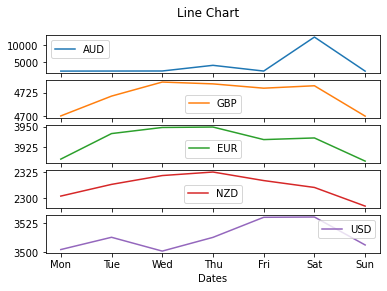

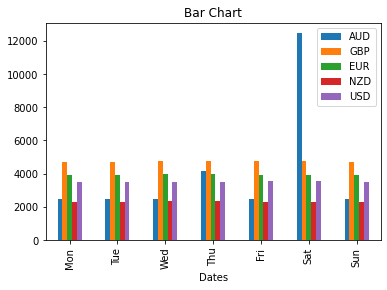

<Figure size 432x288 with 0 Axes>

In [57]:
def exchange_rate():
    """
    Analye Exchange Rate Logs as a report.
    This data is got from scraping the web on a schedule by Celery (using my Flask application), and saving it in a text file.
    In this function, I simply read from the text file. In my main Flask app, the reports/charts are additionally displayed in an iFrame on the web page.
    """

    now = datetime.now()
    
    data = pd.read_csv('static/downloads/exchange-rates.txt', header=None)
    data.columns=['AUD', 'GBP', 'EUR', 'NZD', 'USD']

    data['Dates'] = data['AUD'] #.apply(lambda s: s.split(':')[0])
    data.set_index('Dates', inplace=True, drop=True)
    data = data.applymap(lambda s: s.split('(')[1].split(')')[0]) #(lambda s: s.str.upper().split(':')[0])

    raw_data = data.copy().reset_index()
    raw_data['Dates'] =  raw_data['Dates'].map(lambda s: s.split(':')[0])
    raw_data = format_df(raw_data.sort_values(by=['Dates']), caption='Raw Data')

    data.index = data.index.map(lambda s: s.split(':')[0]) #the -5 removes time element
    data.index = pd.to_datetime(data.index)
    data = data.apply(pd.to_numeric)
    #data.describe()
    data.index.dtype

    start_date = datetime(2021, 1, 28)
    end_date = datetime(2023, 1, 28)
    data = data.loc[(data.index >= start_date) & (data.index <= end_date)]
    data=data.drop_duplicates(['AUD', 'GBP'], keep='last')

    #drop rows with duplicated index (dates)
    data = data[~data.index.duplicated(keep='first')]

    #get weekday index - change index to weekday
    data.sort_index(key=lambda x: x.weekday, ascending=True, inplace=True)
    data.index = data.index.strftime('%a')  # weekday - A or a,  month - B or b,

    #group by index column
    data = data.groupby(['Dates'], sort = False).mean()

    sub_plots = get_subplots(data) #using plotly go (graph objects)

    fig1 = data.plot(kind='line', subplots=True, title='Line Chart')
    fig2 = data.plot(kind='bar', subplots=False, title='Bar Chart')

    plt.show()

    data = format_df(data, caption='Processed Data') #doesnt work if there are duplicates, i.e. if rows with duplicated index (dates) were not dropped above

    #display(HTML(aHtml))
    sub_plots.show()
    plt.clf() #clear
    #plt.cla() #clear

exchange_rate() 


In [58]:
def read_telephone_logs():

    import pandas as pd
    na_values = ['None']
    df_kampala = pd.read_csv('D:/Temp/kampala_calls.csv', na_values=na_values, dtype={'pin_code': str, 'src': str, 'dest': str})
    df_nairobi = pd.read_csv('D:/Temp/nairobi_calls.csv', na_values=na_values, dtype={'pin_code': str, 'src': str, 'dest': str})

    df_kampala['site'] = 'KAMPALA'
    df_nairobi['site'] = 'NAIROBI'

    df_calls = pd.concat([df_kampala, df_nairobi], keys=['KAMPALA', 'NAIROBI'])

    df_users = pd.read_csv('D:/Temp/people.csv', usecols=['pin_code', 'department', 'call_limit'], na_values=na_values, dtype={'pin_code': str})
    df_users.loc[df_users['department'] != 'Training', 'department'] = 'Sales'
    df_users.describe(include='all')

    df_raw = pd.merge(df_calls, df_users, on='pin_code')

    #filtration
    not_null_pin_code = df_raw['pin_code'].notna()
    status_answered = df_raw['status']=='ANSWERED'
    df_raw = df_raw.loc[not_null_pin_code & status_answered]

    df_raw.loc[:4, ['calldate', 'duration']]

    return df_raw

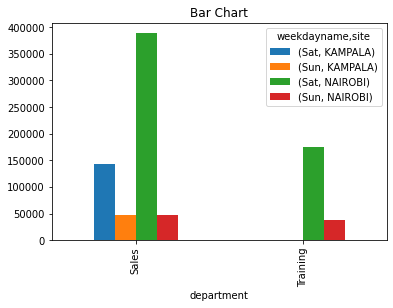

weekdayname,Sat,Sun,Sat,Sun
site,KAMPALA,KAMPALA,NAIROBI,NAIROBI
department,,,,
Sales,"143,285","47,259","389,009","46,656"
Training,0,0,"175,668","37,132"


,id,calldate,duration,telco,country_tel_code,rate,status,site,department,call_limit
0,"1,513,924",2016-03-17 11:04:16,60,,78,264,ANSWERED,KAMPALA,Sales,"20,000"
2,"1,513,941",2016-03-17 12:30:16,13,,77,264,ANSWERED,KAMPALA,Sales,"20,000"
4,"1,513,944",2016-03-17 12:38:38,11,,70,298,ANSWERED,KAMPALA,Sales,"20,000"
5,"1,513,945",2016-03-17 12:44:40,329,,70,298,ANSWERED,KAMPALA,Sales,"20,000"
6,"1,513,983",2016-03-18 05:16:27,12,,41,175,ANSWERED,KAMPALA,Sales,"20,000"
7,"1,514,036",2016-03-18 08:33:38,11,,41,175,ANSWERED,KAMPALA,Sales,"20,000"
11,"1,514,180",2016-03-21 07:18:20,19,,41,175,ANSWERED,KAMPALA,Sales,"20,000"
12,"1,514,190",2016-03-21 08:31:54,166,,77,264,ANSWERED,KAMPALA,Sales,"20,000"
15,"1,514,199",2016-03-21 08:51:17,270,,80,0,ANSWERED,KAMPALA,Sales,"20,000"
16,"1,514,286",2016-03-21 12:04:24,14,,41,175,ANSWERED,KAMPALA,Sales,"20,000"


<Figure size 432x288 with 0 Axes>

In [59]:
def report_telephone_logs():
    
    #probe the data
    df = read_telephone_logs()
    df_raw = df.copy()
    df.head(10)
    df.tail(10)
    df['telco'].unique()

    #convert column data types
    df['calldate'] = pd.to_datetime(df['calldate'], format='%Y-%m-%d %H:%M:%S')
    df['country_tel_code'] = df['country_tel_code'].apply(str)

    df['weekdayname'] = df.apply(lambda row: row['calldate'].strftime('%a'), axis = 1)

    #process data
    weekends = df['calldate'].apply(lambda x: x.weekday()).isin([5,6])
    df = df.loc[weekends] #calls made over weekends
    df.set_index('calldate', drop=True, inplace=True)

    df.index = df.index.weekday #day of week

    df = df.groupby(['weekdayname', 'site', 'department'], sort=False)['duration'].sum().unstack(['weekdayname', 'site']) #.loc[:, 'duration']
    df.plot(kind='bar', subplots=False, title='Bar Chart')
    plt.show()
    plt.clf() #clear
    #plt.cla() #clear
    display(HTML(format_df(df.fillna(0)).render()))
    df_raw_formatted = format_df(df_raw.drop(columns=['pin_code', 'src', 'dest']).fillna('').iloc[:10]) #minus 'pin_code', 'src', 'dest'
    display(HTML(df_raw_formatted.render())) #important for Styler, otherwise you cannot just print
    #display(HTML(df_raw_formatted))

report_telephone_logs()

In [60]:
# merge dfs
# join dfs
# concat dfs
# stack and unstack dfs

data0 = {'A': ['sA1','sA2','sA3','sA4'], 'B': [11,11,22,44], 'C': [111,222,333,444]}
df0 = pd.DataFrame(data0)

data1 = {'A': ['A1','A2','A3','A4'], 'B': [11,11,22,44], 'C': [111,222,333,444]}
df1 = pd.DataFrame(data1)

data2 = {'A': ['A1','A2','A3'], 'b': [11,11,22], 'c': [111,222,333]}
df2 = pd.DataFrame(data2)

df3 = pd.merge(df1, df2, on='A', how='outer')
#df3 = pd.merge(df1, df2, left_on='A', right_on='A', how='outer')
#df3 = pd.merge(df1, df2, on='A', how='inner') #inner join produces only rows that match in both dfs; right join produces complete set of records from df2 with any(??) matching records in df1
df3

#df4 = pd.concat([df0, df1], keys=['df0', 'df1'])
df4 = pd.concat({'df0': df0, 'df1': df1}) #another way to pass keys
#df4.loc['df0'] #retrieve only df0 records
#display(HTML(format_df(df4).render()))
#display(HTML(format_df(df4).render()))
df_formatted = format_df(df4)

c_neg = pd.IndexSlice[df_formatted.data.loc[~(df_formatted.data['C']>df_formatted.data['B'])].index, 'C']
df_formatted.bar(subset=['B'], color='green', vmin=0.0, vmax=100.0) \
    .bar(subset=c_neg, color='blue', vmin=0.0, vmax=500.0)

df_formatted
#HTML(format_df(df4).render())
#format_df(df4)

In [61]:
import numpy as np
ls1 = [[1,2,3],[4,5,6]]
ls2 = [[1,20,3],[4,50,6]]

arr1 = np.array(ls1)
# array([[1, 2, 3],
#        [4, 5, 6]])

arr2 = np.array(ls2)
# array([[ 1, 20,  3],
#        [ 4, 50,  6]])

arr3 = arr1*arr2
# array([[  1,  40,   9],
#        [ 16, 250,  36]])

type(arr3) # numpy.ndarray
arr3.ndim # 2 - the number of axes (dimensions) of the array
arr3.shape # (2, 3) - dimensions
arr3.size # 6 - total number of elements

np.zeros((3, 4)) #3 by 4 array of 0s
np.ones((3, 4)) #3 by 4 array of 1s
np.zeros(4) # one-dimensional array of 4 0s - better use np.arange

np.arange(10, 30, 5) #analogous to the Python built-in range

a = np.arange(10, 30, 5) # 1d array

b = np.arange(12).reshape(4, 3)     # 2d array - array of arrays
b
np.ones(10, dtype=np.int32).sum()

10